# Demo Notebook for Metrics Correlation Model Testing

#### [Download notebook](https://github.com/opensearch-project/opensearch-py-ml/blob/main/docs/source/examples/demo_metrics_correlation.ipynb)


## Introduction

This notebook contains an introduction to the [metrics correlation](https://opensearch.org/docs/latest/ml-commons-plugin/algorithms/#metrics-correlation) algorithm released in OpenSearch 2.7. We will work through an example using data from the [Server Machine Dataset](https://github.com/NetManAIOps/OmniAnomaly) and include commentary on the objective, configuration, and output of the algorithm itself.

## Step 0: Imports

Please install the following packages from the terminal if you haven't already. They can be also installed from the notebook by uncommenting and executing the line in the second code block.

In [ ]:
%load_ext autoreload
%autoreload 2

In [4]:
# !pip install pandas matplotlib numpy opensearch-py

In [2]:
# import this to stop opensearch-py-ml from yelling every time a DataFrame connection made
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import opensearch_py_ml as oml
from opensearchpy import OpenSearch

# Import standard test settings for consistent results
from opensearch_py_ml.conftest import *

## Step 1: Set up clients and define helper functions


In [6]:
CLUSTER_URL = 'https://localhost:9200'

def get_os_client(cluster_url = CLUSTER_URL,
                  username='admin',
                  password='admin'):
    """
    Get OpenSearch client
    :param cluster_url: cluster URL like https://ml-te-netwo-1s12ba42br23v-ff1736fa7db98ff2.elb.us-west-2.amazonaws.com:443
    :return: OpenSearch client
    """
    client = OpenSearch(
        hosts=[cluster_url],
        http_auth=(username, password),
        verify_certs=False,
        timeout = 30
    )
    return client


In [7]:
client = get_os_client()

In [8]:
#connect to ml_common client with OpenSearch client
from opensearch_py_ml.ml_commons import MLCommonClient
ml_client = MLCommonClient(client)

## Step 2: Preparing data


In [10]:
# Reading csv files as a dataframes
df_pd = pd.read_csv("data/smd_data.csv", header=None)
df_pd

,0,1,...,998,999
0,0.023229,0.019744,...,0.025552,0.024390
1,0.910256,0.910256,...,0.912821,0.912821
2,0.338983,0.339925,...,0.067797,0.068738
3,0.011496,0.012064,...,0.013625,0.014334
4,0.013699,0.013699,...,0.027397,0.041096
5,0.150411,0.166988,...,0.131524,0.131827
6,0.405081,0.399555,...,0.484677,0.481303
7,0.005224,0.008237,...,0.007500,0.009327
8,0.009096,0.007172,...,0.011545,0.009620


In this case study, we consider an example from the recently-released [Server Machine Dataset](https://github.com/NetManAIOps/OmniAnomaly). As the name suggests, the data are performance metrics collected from industrial servers. The servers occasionally suffer performance degradations that appear in the metrics data. Here, we take the role of an ops engineer investigating recent metrics data to understand whether and how these issues have occurred.

The individual metrics can display very different behavior, yet correlating issues across metrics is essential for detecting and diagnosing issues with the server. To start, let’s plot the data that we’ll be working with in this case study. It consists of 9 metrics observed across 1000 timestamps. We have normalized each metrics time series such that its values lie between 0 and 1.

Text(0.5, 0, 'Timestamp')

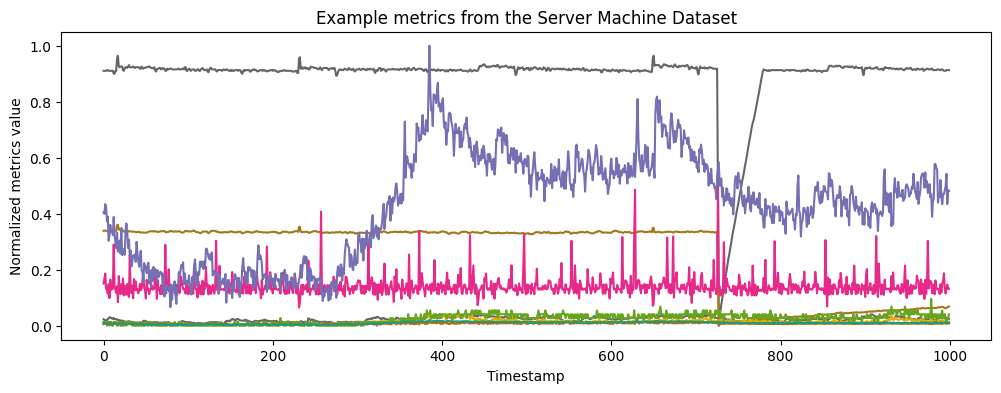

In [42]:
M, T = df_pd.shape

plt.figure(figsize=(12,4))
cm = plt.get_cmap('Dark2')
vals = np.arange(M)[::-1]

for i in range(M):
    plt.plot(df_pd.iloc[i], color = cm(vals[i]))

plt.title('Example metrics from the Server Machine Dataset')
plt.ylabel('Normalized metrics value')
plt.xlabel('Timestamp')

## Step 3: Metrics correlation


The metrics correlation algorithm finds events in a set of metrics data, where an event is defined as a window in time where multiple metrics simultaneously display anomalous behavior. Given a time span and a total set of metrics, the metrics correlation algorithm automatically determines how many events occurred, when they occurred, and which metrics were involved in each event. This algorithm requires no prior training and minimal configuration.

Let’s see how it works for the Server Machine Dataset example.

In [12]:
input_json = {"metrics": df_pd.values.tolist()}

Now we can run the metrics correlation algorithm on this data via the execute API:

In [14]:
results = ml_client.execute(
    algorithm_name = "METRICS_CORRELATION",
    input_json = input_json
)

The results are given as a list, where each element of the list is an event that the algorithm has discovered in the data. If the length of the list is zero, then the algorithm has discovered no events in the given input data.

In this case, the algorithm discovers two events:

In [15]:
len(results['output']['inference_results'])

2

Every event is represented as a dictionary with three fields:

* The event window: a list consisting of the start and end index values for the event. This describes when the event occurred.
* The suspected metrics: a list with the indices of all metrics that are part of the event. This describes which metrics were correlated during the time of the event.
* The event pattern: an array of length T where each value indicates the relative intensity of the event at the corresponding timestamp. This is the algorithm's underlying "idea" of the event; roughly, it indicates where in time the algorithm has focused to define the event.

In [16]:
results['output']['inference_results'][0].keys()

dict_keys(['event_window', 'event_pattern', 'suspected_metrics'])

## Step 4: Result visualization


Below, we implement a plotting function that uses each of these fields to visually display an event. This function plots all of the input data as above, but highlights the metrics that were involved in the event and shades the interval when the event occurred. It also plots the event pattern.

In [17]:
from matplotlib.lines import Line2D

def plot_event(event, metrics):
    M, _ = metrics.shape
    _, axs = plt.subplots(2, 1, figsize = (12,6))

    # plot non-event metrics in grayscale
    for i in range(M):
        if i not in event['suspected_metrics']:
            axs[0].plot(metrics.iloc[i], color = 'lightgray')

    # highlight event metrics
    for i in range(M):
        if i in event['suspected_metrics']:
            axs[0].plot(metrics.iloc[i], color = 'maroon')

    # shade event window
    axs[0].fill_between(event['event_window'], 0, 1, color='skyblue', alpha=0.6, label = 'Event window')
    axs[0].set_ylabel('Normalized metrics value')

    # add legend
    sus_met = Line2D([0],[0], label='Suspected metrics', color='maroon')
    unsus_met = Line2D([0],[0], label='Other metrics', color='lightgray')
    handles, _ = axs[0].get_legend_handles_labels()
    handles.extend([sus_met, unsus_met])
    axs[0].legend(loc='upper left', handles=handles, facecolor='white', framealpha=1)

    # plot (scaled) event pattern
    Max = max(event['event_pattern'])
    axs[1].plot([val/Max for val in event['event_pattern']], color = 'darkorange', alpha=0.6, linewidth=3.0, label='Intensity')
    axs[1].set_ylabel('Event pattern')
    axs[1].set_xlabel('Timestamp')

    plt.show()

Now we can easily visualize both events discovered in the data:


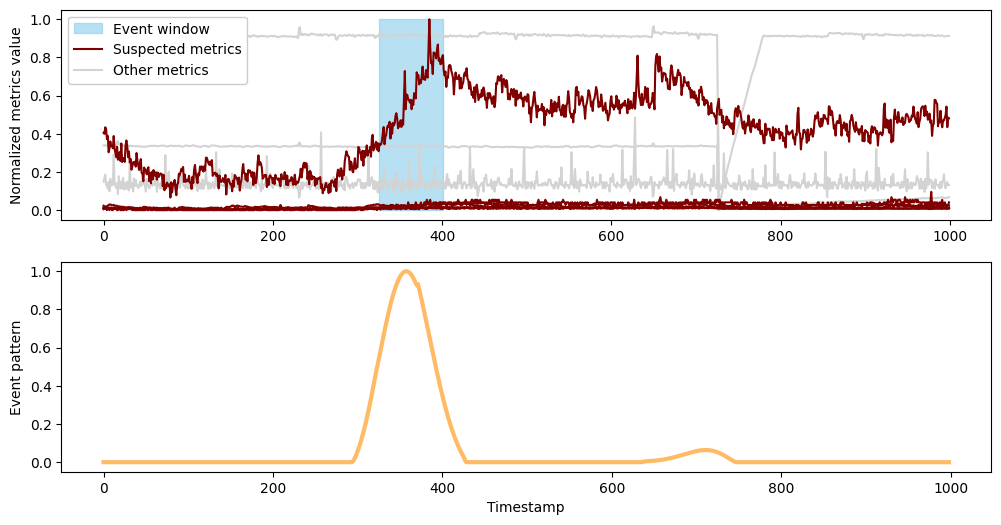

In [18]:
plot_event(results['output']['inference_results'][0], df_pd)

In [39]:
# Event window for first event:
print("Event window for first event", results['output']['inference_results'][0]['event_window'])

# Number of suspected metrics:
print("Suspected metrics", results['output']['inference_results'][0]['suspected_metrics'])

Event window for first event [325.0, 401.0]
Suspected metrics [0, 3, 4, 6, 7, 8]


The first event occurs between timestamps
325
 and
401
 and it features the large rise that was clearly visible from the first plot of the data. However, the algorithm has found and associated with this rise several other metrics that display more subtle changes during this window.
 
From the plot above, it appears that only one metric significantly contributes to the event. However, upon closer examination without the dominant metric, we observe shifts in other metrics during the same period. To visually demonstrate this, we have plotted these other metrics below.

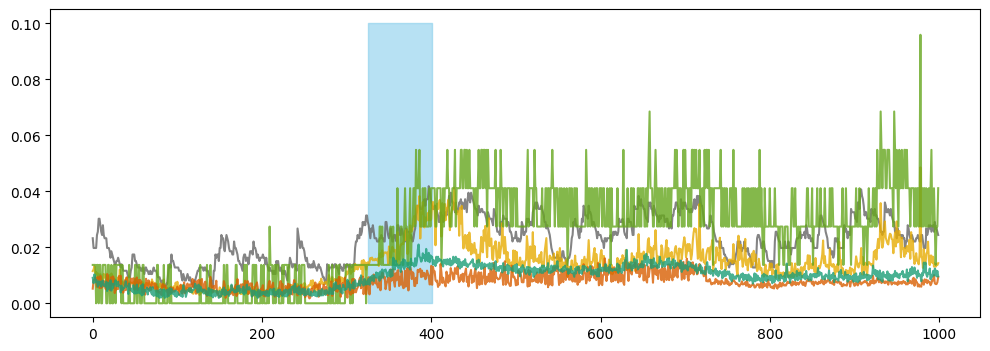

In [44]:
ixs = [x for x in results['output']['inference_results'][0]['suspected_metrics'] if x!=6]
event_start, event_end = results['output']['inference_results'][0]['event_window']
plt.figure(figsize=(12, 4))

for i in ixs:
    plt.plot(df_pd.iloc[i], alpha=0.8, color = cm(vals[i]))
    
plt.fill_between(results['output']['inference_results'][0]['event_window'], 0, 0.1, color='skyblue', alpha=0.6)
plt.show()

Next we'll plot the second event.

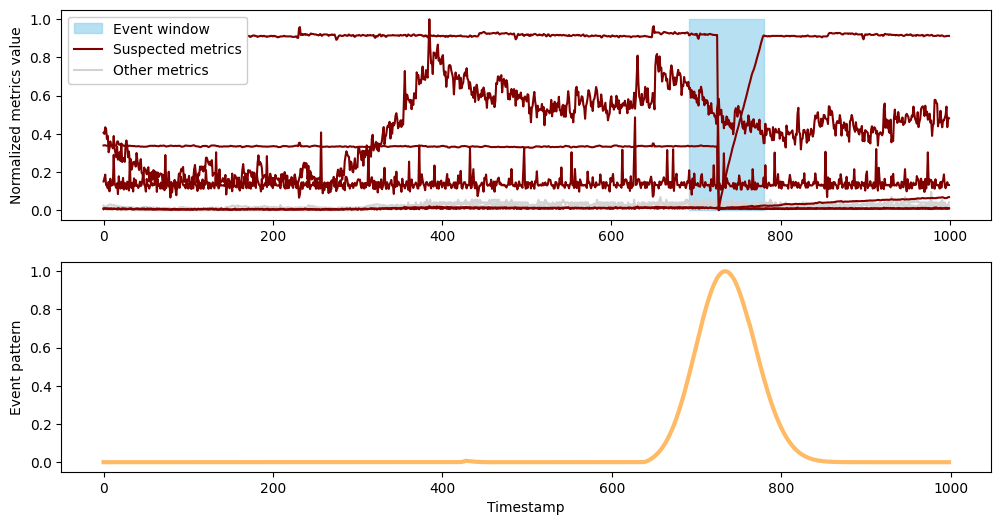

In [20]:
plot_event(results['output']['inference_results'][1], df_pd)

In [40]:
# Event window for second event:
print("Event window for second event", results['output']['inference_results'][1]['event_window'])

# Number of suspected metrics:
print("Suspected metrics", results['output']['inference_results'][1]['suspected_metrics'])

Event window for second event [692.0, 780.0]
Suspected metrics [1, 2, 5, 6, 7, 8]



The second event occurs between timestamps
692
 and
780
, capturing the sharp drop that was again clearly visible in the initial plot. Here, the drop has been automatically correlated with a second, smaller drop, along with several metrics whose behavior changes from flat to a slow rise during this interval.
